In [ ]:
## Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d30ebaaa-39fb-b65f-1697-f97143b2f4a6)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-10-27 20:19:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-27 20:19:50 (124 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Get a text dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-10-27 20:26:16--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2023-10-27 20:26:16 (144 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Unzip data
unzip_data("nlp_getting_started.zip")

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How manu total samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df) -5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
on town of salem i just melted ice cube bc im the arsonist :D

---

Target: 1 (real disaster)
Text:
I just checked in! ÛÒ at On Fire on @ZomatoAUS #LoveFood http://t.co/9l5kqykrbG

---

Target: 1 (real disaster)
Text:
Calgary area tornado warnings end as thunderstorms move eastward - CBC.ca: CBC.ca Calgary area tornado warnings endÛ_ http://t.co/ST9jPZ8Y24

---

Target: 0 (not real disaster)
Text:
@JJ_DIRTY @MLSTransfers @greggmair oh Gio was my backup. But with SKC next and BWP getting a crack at NYCFC + injury I went BWP. Lol wrong

---

Target: 1 (real disaster)
Text:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/2AO97o2a9D

---



###Splot data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,  # use 10% of training data for validation split
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

## Converting text into numbers

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
### Text vectorization (tokenization)
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=16000, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # hwo to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [ ]:
len(train_sentences[0].split())

7

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [129]:
# Setup text vectorization variables
max_vocab_length = 10000    # max number of words to have in our vocabulary
max_length = 15   # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [130]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [131]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

###Creating an Embedding using an Embedding Layer

In [132]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,    # set input shape
                             output_dim=128,          # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length    # how long is each input
                             )
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04149752,  0.00758685, -0.00740037, ..., -0.00559134,
         -0.03832682, -0.04984021],
        [-0.01106904,  0.0257327 , -0.02712578, ..., -0.02594813,
          0.04670462,  0.01745449],
        [ 0.0007122 , -0.01136347, -0.00859538, ..., -0.04325612,
         -0.0012201 ,  0.00567763],
        ...,
        [-0.04149752,  0.00758685, -0.00740037, ..., -0.00559134,
         -0.03832682, -0.04984021],
        [ 0.01293472, -0.00479031, -0.04389725, ..., -0.01599789,
         -0.03630505, -0.04985291],
        [ 0.01293472, -0.00479031, -0.04389725, ..., -0.01599789,
         -0.03630505, -0.04985291]]], dtype=float32)>

##Modelling a text dataset (using keras Sequential API)

###Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
import tensorflow as tf
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1, ) , dtype = 'string'),
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=max_vocab_length,    # set input shape
                              output_dim=128,          # output shape
                              embeddings_initializer="uniform",
                              input_length=max_length),    # how long is each input
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 6s 29ms/step - loss: 0.5886 - accuracy: 0.7085 - val_loss: 0.5234 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4277 - accuracy: 0.8235 - val_loss: 0.4696 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3378 - accuracy: 0.8644 - val_loss: 0.4572 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2777 - accuracy: 0.8949 - val_loss: 0.4651 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2318 - accuracy: 0.9134 - val_loss: 0.4865 - val_accuracy: 0.7808


### Model 2: LSTM

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1, ) , dtype = 'string'),
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=max_vocab_length,    # set input shape
                              output_dim=128,          # output shape
                              embeddings_initializer="uniform",
                              input_length=max_length),    # how long is each input
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231027-212730
Epoch 1/5
215/215 [==============================] - 43s 39ms/step - loss: 0.5083 - accuracy: 0.7491 - val_loss: 0.4484 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3147 - accuracy: 0.8726 - val_loss: 0.4910 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2174 - accuracy: 0.9237 - val_loss: 0.5427 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1651 - accuracy: 0.9409 - val_loss: 0.5832 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1141 - accuracy: 0.9596 - val_loss: 0.6965 - val_accuracy: 0.7651


### Model 5: Conv1D

In [135]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1, ) , dtype = 'string'),
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=max_vocab_length,    # set input shape
                              output_dim=128,          # output shape
                              embeddings_initializer="uniform",
                              input_length=max_length),    # how long is each input
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid"),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [136]:
# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [137]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20231028-002702
Epoch 1/5
215/215 [==============================] - 12s 40ms/step - loss: 0.5489 - accuracy: 0.7231 - val_loss: 0.4742 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3334 - accuracy: 0.8631 - val_loss: 0.4870 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2030 - accuracy: 0.9289 - val_loss: 0.5744 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1254 - accuracy: 0.9556 - val_loss: 0.6437 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0903 - accuracy: 0.9708 - val_loss: 0.7197 - val_accuracy: 0.7743


### Model 0: Retrain base line with 10% of the data

In [58]:
len(train_df_shuffled["text"])*0.1

761.3000000000001

In [59]:
train_df_shuffled["text"][:762]

2644    So you have a new weapon that can cause un-ima...
2227    The f$&amp;@ing things I do for #GISHWHES Just...
5448    DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
132     Aftershock back to school kick off was great. ...
6845    in response to trauma Children of Addicts deve...
                              ...                        
1034                 @Deeeznvtzzz bring the body bags tho
3107    Fr cuz I risk being electrocuted every shower ...
4379    RT NotExplained: The only known image of infam...
2288    Read this already in '14 but it was and remain...
4080         @chojo everyone hail to the pumpkin king!!!!
Name: text, Length: 762, dtype: object

In [60]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"][:762].to_numpy(),
                                                                            train_df_shuffled["target"][:762].to_numpy(),
                                                                            test_size=0.1,  # use 10% of training data for validation split
                                                                            random_state=42)

In [61]:
len(train_sentences)

685

In [62]:
len(val_sentences)

77

In [63]:
685+77

762

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),   # convert words to numbers using tfidf
    ("clf", MultinomialNB())  # model the text
])

In [67]:
# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [68]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 75.32%


In [69]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [70]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [71]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 75.32467532467533,
 'precision': 0.7564344746162928,
 'recall': 0.7532467532467533,
 'f1': 0.7432899624194225}

The baseline with 100% of data has a percentage of accuracy of: 79.27%

## Fine-tuning TF Hub Universal Sentence Encoder model


In [72]:
import tensorflow_hub as hub
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=True,
                                       name="USE")

# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    #layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 256798337 (979.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,  # use 10% of training data for validation split
                                                                            random_state=42)

In [75]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231027-221750
Epoch 1/5
215/215 [==============================] - 98s 442ms/step - loss: 0.4641 - accuracy: 0.7945 - val_loss: 0.4277 - val_accuracy: 0.8189
Epoch 2/5
215/215 [==============================] - 30s 137ms/step - loss: 0.2481 - accuracy: 0.9102 - val_loss: 0.4267 - val_accuracy: 0.8255
Epoch 3/5
215/215 [==============================] - 24s 112ms/step - loss: 0.0851 - accuracy: 0.9755 - val_loss: 0.6094 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 23s 108ms/step - loss: 0.0458 - accuracy: 0.9854 - val_loss: 0.6414 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 23s 105ms/step - loss: 0.0355 - accuracy: 0.9885 - val_loss: 0.6550 - val_accuracy: 0.7795


In [88]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [87]:
test = test_df["text"]
test

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

## 4. Retrain the best model and competition

In [81]:
import tensorflow_hub as hub
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=True,
                                       name="USE")

# Create model using the Sequential API
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 256830721 (979.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
# Train a classifier on top of USE pretrained embeddings
model_7_history = model_7.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231027-223756
Epoch 1/5
215/215 [==============================] - 167s 468ms/step - loss: 0.4529 - accuracy: 0.7951 - val_loss: 0.4355 - val_accuracy: 0.8071
Epoch 2/5
215/215 [==============================] - 28s 129ms/step - loss: 0.2374 - accuracy: 0.9061 - val_loss: 0.4595 - val_accuracy: 0.7979
Epoch 3/5
215/215 [==============================] - 25s 117ms/step - loss: 0.0748 - accuracy: 0.9752 - val_loss: 0.6395 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 22s 104ms/step - loss: 0.0378 - accuracy: 0.9860 - val_loss: 0.6623 - val_accuracy: 0.7979
Epoch 5/5
215/215 [==============================] - 24s 111ms/step - loss: 0.0280 - accuracy: 0.9882 - val_loss: 0.6388 - val_accuracy: 0.7992


In [84]:
# Make predictions with my best model
model_7_pred_probs = model_7.predict(test)
model_7_pred_probs[:10]

102/102 [==============================] - 1s 10ms/step


array([[0.9969393 ],
       [0.99763143],
       [0.99724066],
       [0.9975458 ],
       [0.9978593 ],
       [0.9736202 ],
       [0.01174326],
       [0.00124873],
       [0.00108771],
       [0.00119782]], dtype=float32)

In [85]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [100]:
model_7_preds.numpy()

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [101]:
from numpy import savetxt
data = model_7_preds.numpy()


In [109]:
df = pd.DataFrame(data, columns=['target'])
df1 = pd.DataFrame(data)
df1['id'] = range(1, len(df) + 1)
df1

,0,id
0,1.0,1
1,1.0,2
2,1.0,3
3,1.0,4
4,1.0,5
...,...,...
3258,0.0,3259
3259,1.0,3260
3260,1.0,3261
3261,1.0,3262


In [110]:
df1.head()

,0,id
0,1.0,1
1,1.0,2
2,1.0,3
3,1.0,4
4,1.0,5


In [107]:
import numpy as np
int_array = data.astype(np.int32)
int_array

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [118]:
df1.columns

Index([0, 'id'], dtype='object')

In [115]:
# save to csv file
df1.to_csv('my_dataframe1.csv', index=False)

## 5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?

In [122]:
test_sentences = test_df['text'].to_numpy()

# Checking the shapes
test_sentences.shape

(3263,)

In [123]:
# Getting the model predictions

def give_preds(model, test_sentences):
  '''
  This model takes a model and the test sentences as input.
  Returns the prediction array of [0,1.....]
  '''
  pred_probs = model.predict(test_sentences)
  preds = tf.squeeze(tf.round(pred_probs))
  preds = tf.cast(preds , dtype = tf.int32)

  return preds

In [139]:
# Getting the predictions for our 3 models
model_1_preds = give_preds(model_1 , test_sentences)
model_2_preds = give_preds(model_2 ,test_sentences)
model_5_preds = give_preds(model_5 , test_sentences)

# Checking the shapes of our prediction
model_1_preds.shape , model_2_preds.shape , model_5_preds.shape

102/102 [==============================] - 0s 2ms/step


(TensorShape([3263]), TensorShape([3263]), TensorShape([3263]))

In [141]:
model_1_preds[:5] , model_2_preds[:5] , model_5_preds[:5]

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 0, 1, 0, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 0, 1, 1, 1], dtype=int32)>)

In [142]:
# Creating a dataframe of our predictions

preds_df = pd.DataFrame({'USE_model': model_1_preds ,
              'LSTM_model': model_2_preds ,
              'Conv1D_model': model_5_preds})
preds_df.head()

,USE_model,LSTM_model,Conv1D_model
0,0,1,1
1,0,0,0
2,1,1,1
3,0,0,1
4,0,1,1


In [143]:
# Majority voted predictions of our model
preds_df['majority_vote_preds'] = preds_df.mode(axis = 1)
preds_df.head()

,USE_model,LSTM_model,Conv1D_model,majority_vote_preds
0,0,1,1,1
1,0,0,0,0
2,1,1,1,1
3,0,0,1,0
4,0,1,1,1


In [144]:
# Converting the column into a numpy array
mode_preds_array = preds_df['majority_vote_preds'].to_numpy()
mode_preds_array

array([1, 0, 1, ..., 1, 0, 1], dtype=int32)

## 6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

In [145]:
# Funtion taken from the course
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [149]:
# Predictions on the validation sentences
val_preds = give_preds(model_5 , val_sentences)

# Creating a array of our class names
class_names = ['not_a_disaster' , 'disaster']

# Checking the preds and true labels shape
val_preds.shape , val_labels.shape

24/24 [==============================] - 0s 2ms/step


(TensorShape([762]), (762,))

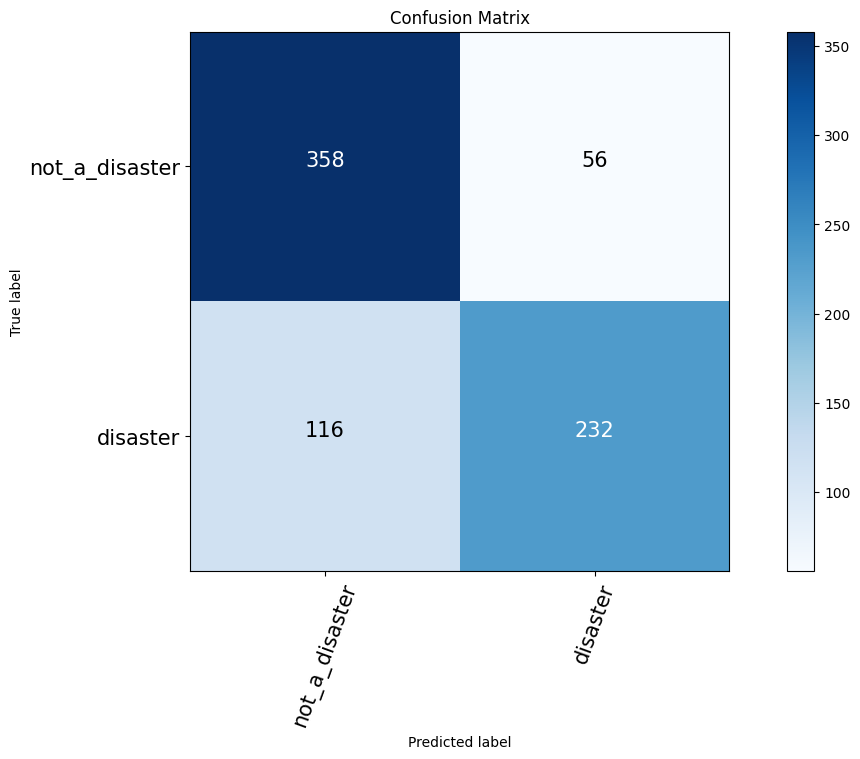

In [150]:
# Plotting the confusion matrix
make_confusion_matrix(y_true= val_labels ,
                      y_pred = val_preds ,
                      classes = class_names ,
                      figsize= (15 , 7),
                      norm = False ,
                      savefig = True ,
                      text_size = 15)